In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [2]:
train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')

In [3]:
genetic_selected_names = ['ptt_min','inr_max','calcium_min.1','temperature_mean','glucose_min','glucose_mean','weight_admit','aniongap_max','aniongap_min','potassium_min.1','bicarbonate_max.1','chloride_max.1','gcs_verbal','hemoglobin_min.1','hematocrit_min.1','bun_max','gcs_eyes','resp_rate_max','resp_rate_min','spo2_mean','spo2_min','dbp_min','sbp_mean','sbp_min','heart_rate_max','heart_rate_mean','race','admission_age']
genetic_selected_names.append('aki')
train = train.loc[:, genetic_selected_names]
test = test.loc[:, genetic_selected_names]

## Try

In [5]:
def train_model(train, test, model):
    y = train['aki'].astype(float)
    X = train.drop(['aki'], axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=20)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print("验证集上表现：")
    print("Accuracy:", accuracy)
    print(classification_report(y_valid, y_pred))

    y_test = test['aki'].astype(float)
    X_test = test.drop(['aki'], axis=1)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('测试集上表现：')
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))
    return model

In [10]:
model = SVC(kernel='rbf', decision_function_shape='ovo')
train_model(train, test, model)


验证集上表现：
Accuracy: 0.3268217054263566
              precision    recall  f1-score   support

         0.0       0.33      0.99      0.49      3157
         1.0       0.00      0.00      0.00      1904
         2.0       0.27      0.01      0.03      3059
         3.0       0.00      0.00      0.00      1555

    accuracy                           0.33      9675
   macro avg       0.15      0.25      0.13      9675
weighted avg       0.19      0.33      0.17      9675

测试集上表现：
Accuracy: 0.3157894736842105
              precision    recall  f1-score   support

         0.0       0.32      0.99      0.48       808
         1.0       0.00      0.00      0.00       461
         2.0       0.17      0.01      0.01       837
         3.0       0.00      0.00      0.00       440

    accuracy                           0.32      2546
   macro avg       0.12      0.25      0.12      2546
weighted avg       0.16      0.32      0.16      2546



SVC(decision_function_shape='ovo')

In [16]:
def search_hyperparameter_SVM(train, test, data_name='', param_dist=None):
    y = train['aki'].astype(float)
    X = train.drop(['aki'], axis=1)

    if param_dist is None:
        param_dist = {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'kernel': ['poly', 'rbf', 'sigmoid', 'precomputed'],
            'gamma': ['scale', 'auto'],
        }

    model = SVC(decision_function_shape='ovo', random_state=20)

    random_search = RandomizedSearchCV(model, param_distributions=param_dist, scoring='accuracy', cv=5, n_iter=10, random_state=20, n_jobs=-1, verbose=2)
    random_search.fit(X, y)

    params = random_search.cv_results_['params']
    scores = random_search.cv_results_['mean_test_score']
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(scores)), scores, '-o')
    plt.ylabel('mean_test_score')
    plt.xticks(range(len(scores)), params, rotation=45)
    plt.title(f'{data_name} Randomized Search CV Results')
    plt.tight_layout()
    plt.show()

    print(f'best_params: {random_search.best_params_}')
    print(f'best_score: {random_search.best_score_}')

    best_model = random_search.best_estimator_
    y_test = test['aki'].astype(float)
    X_test = test.drop(['aki'], axis=1)
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{data_name}最优模型在测试集上的表现:")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

In [17]:
search_hyperparameter_SVM(train, test, "genetic_selected data")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


## Adjust Parameters

### Draw parameters with the Accurancy 2D curve to select the appropriate interval

In [9]:
y_train = train['aki'].astype(float)
X_train = train.drop(['aki'], axis=1)
y_test = test['aki'].astype(float)
X_test = test.drop(['aki'], axis=1)

def train_model_get_accuracy(X_train, y_train, parameters): 
    rf = SVC(
        C = parameters['C'],
        kernel = parameters['kernel'],
        degree = parameters['degree'],
        gamma = parameters['gamma'],
        coef0 = parameters['coef0'],
        shrinking = parameters['shrinking'],
        probability = parameters['probability'],
        class_weight = parameters['class_weight'],
        decision_function_shape = parameters['decision_function_shape']
    )
    rf.fit(X_train, y_train)
    return accuracy_score(y_test,rf.predict(X_test))

def search_hyperparameter(param_name, search_arr, plot_arr, X_train, y_train):
    parameters = {       
        'C':1.0,
        'kernel':'rbf',
        'degree':3,
        'gamma':'scale',
        'coef0':0.0,
        'shrinking':True,
        'probability':False,
        'class_weight':None,
        'decision_function_shape': 'ovr',
    }
    accurancyList = {
        'params':[],
        'precision':[]
    }
    for n in search_arr:
        parameters[param_name] = n
        accurancyList['params'].append(parameters)
        accurancyList['precision'].append(train_model_get_accuracy(X_train, y_train, parameters))

    plt.plot(plot_arr, accurancyList['precision'])
    plt.xlabel(param_name)
    plt.ylabel('accurancy')
    plt.title(f'Accurancy {param_name}')
    plt.show()

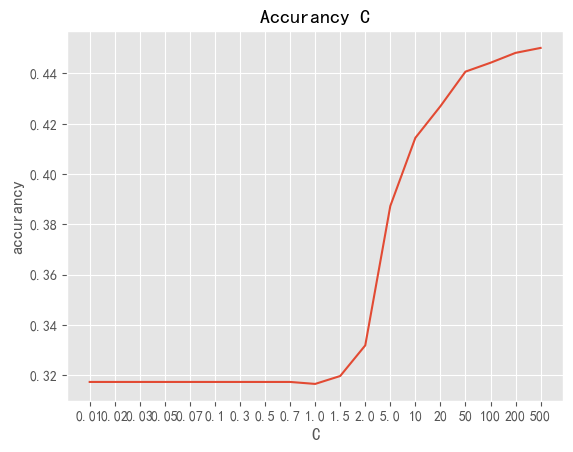

In [7]:
parameters = {       
    'C':1.0,
    'kernel':'rbf',
    'degree':3,
    'gamma':'scale',
    'coef0':0.0,
    'shrinking':True,
    'probability':False,
    'class_weight':None,
    'decision_function_shape': 'ovr',
}
accurancyList = {
    'params':[],
    'precision':[]
}
for n in [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10, 20, 50, 100, 200, 500]:
    parameters['C'] = n
    accurancyList['params'].append(parameters)
    accurancyList['precision'].append(train_model_get_accuracy(X_train, y_train, parameters))

plt.plot([str(i) for i in [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10, 20, 50, 100, 200, 500]],accurancyList['precision'])
plt.xlabel('C')
plt.ylabel('accurancy')
plt.title('Accurancy C')
plt.show()

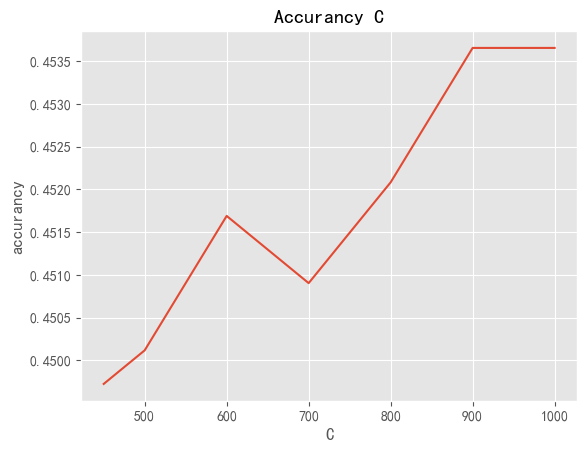

In [15]:
search_hyperparameter('C', 
                      [450, 500, 600, 700, 800, 900, 1000], 
                      [450, 500, 600, 700, 800, 900, 1000], 
                      X_train, 
                      y_train
                    )

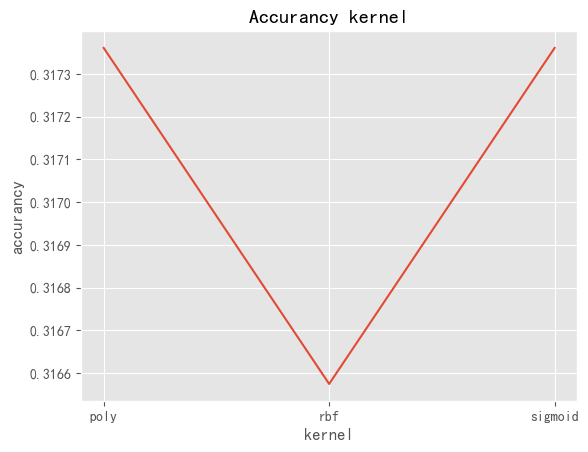

In [11]:
search_hyperparameter('kernel', 
                      ['poly', 'rbf', 'sigmoid'], 
                      ['poly', 'rbf', 'sigmoid'], 
                      X_train, 
                      y_train
                    )

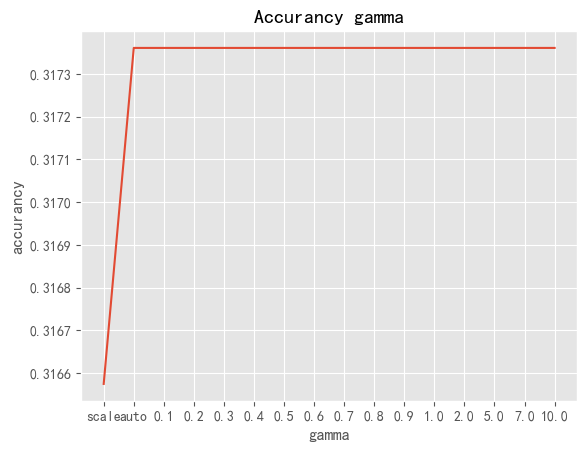

In [12]:
search_hyperparameter('gamma', 
                      ['scale', 'auto', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 5.0, 7.0, 10.0], 
                      [str(i) for i in ['scale', 'auto', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 5.0, 7.0, 10.0]], 
                      X_train, 
                      y_train
                    )

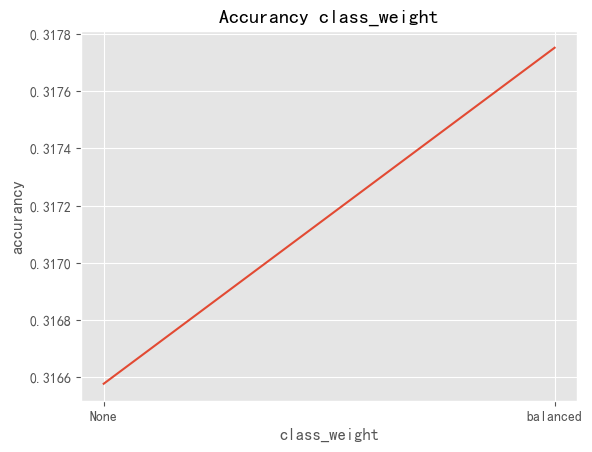

In [13]:
search_hyperparameter('class_weight', 
                      [None, 'balanced'], 
                      ["None", 'balanced'], 
                      X_train, 
                      y_train
                    )

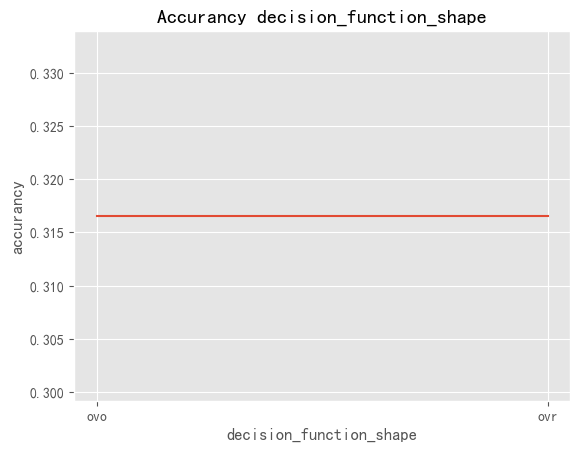

In [14]:
search_hyperparameter('decision_function_shape', 
                      ['ovo', 'ovr'], 
                      ['ovo', 'ovr'], 
                      X_train, 
                      y_train
                    )

### RandomizedSearch

In [4]:
cols = ['ptt_min', 'inr_max', 'calcium_min.1', 'temperature_mean',
       'glucose_min', 'glucose_mean', 'weight_admit', 'aniongap_max',
       'aniongap_min', 'potassium_min.1', 'bicarbonate_max.1',
       'chloride_max.1', 'gcs_verbal', 'hemoglobin_min.1', 'hematocrit_min.1',
       'bun_max', 'gcs_eyes', 'resp_rate_max', 'resp_rate_min', 'spo2_mean',
       'spo2_min', 'dbp_min', 'sbp_mean', 'sbp_min', 'heart_rate_max',
       'heart_rate_mean', 'race', 'admission_age']
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[cols])
scaled_train = pd.DataFrame(scaled_train, columns=cols, index=train.index)
scaled_train = pd.concat([scaled_train, train["aki"]], axis=1)
scaled_test = scaler.transform(test[cols])
scaled_test = pd.DataFrame(scaled_test, columns=cols, index=test.index)
scaled_test = pd.concat([scaled_test, test["aki"]], axis=1)

In [5]:
y_train = scaled_train['aki'].astype(float)
X_train = scaled_train.drop(['aki'], axis=1)
y_test = scaled_test['aki'].astype(float)
X_test = scaled_test.drop(['aki'], axis=1)

In [7]:
param_dist = {
    # 'C':[880, 890, 900, 910, 920],
    "kernel": ['poly', 'sigmoid'],
}
model = SVC(C=900, decision_function_shape="ovr", class_weight='balanced', gamma='auto')
rs = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring="accuracy", cv=5, n_iter=10, n_jobs=-1, random_state=20)
rs.fit(X_train, y_train)

print("best_params", rs.best_params_)
print("best_score", rs.best_score_)
print('------------------------------------------------------------------')
best_model = rs.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

y_pred_proba = best_model.predict_proba(X_test)
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print("SVM AUC (Macro):", auc_macro)
print(classification_report(y_test, y_pred_test))
print('------------------------------------------------------------------')
print(f'train accuracy: {accuracy_train}, test accuracy: {accuracy_test}')

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()